In [1]:
import importlib
import os.path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Optional

import allib
from allib.models.al import ActiveLearningPipeline, RandomMetric, UncertainMetric
from allib.datasets import get_uci_db, load_uci, Dataset
from allib.metrics import get_metrics
from allib.models import get_pipeline

from sklearn import preprocessing
from tqdm.notebook import tqdm 
from catboost import CatBoostClassifier, to_classifier, sum_models
importlib.reload(allib)

<module 'allib' from 'E:\\Courses\\COMP8800\\Projects\\CatBoostPlayground\\allib\\__init__.py'>

In [2]:
_c_md = get_pipeline("catboost")
_lr_md = get_pipeline("logistic")

In [3]:
params = {
    "init_size": 30,
    "batch_size": 20,
    "random_state": 0
}
iris_dataset = load_uci("iris")
iris_dataset._data = iris_dataset._data[["sepal_length", "petal_width"]]
unc_iris = iris_dataset.with_metric(UncertainMetric(**params))
rand_iris = iris_dataset.with_metric(RandomMetric(**params))
unc_etp_iris = iris_dataset.with_metric(UncertainMetric(name="entropy", **params))

c_md = _c_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=unc_iris, **params)
c_md_rand = _c_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=rand_iris, **params)
c_md_etp = _c_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=unc_etp_iris, **params)

In [4]:
c_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
c_md_rand.start()

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
c_md_etp.start()

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
unc_iris.reset()
rand_iris.reset()
unc_etp_iris.reset()
lr_md = _lr_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=unc_iris, **params)
lr_md_rand = _lr_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=rand_iris, **params)
lr_md_etp = _lr_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=unc_etp_iris, **params)

In [5]:
lr_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

D:\anaconda3\envs\COMP8800\lib\site-packages\matplotlib\colors.py:669: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.N = int(N)  # ensure that N is always int


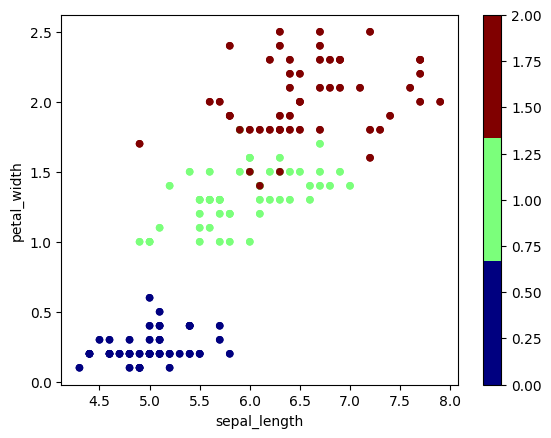

In [8]:
cmap = plt.get_cmap('jet', iris_dataset._label.nunique())
sct = iris_dataset._data.plot.scatter(x="sepal_length", y="petal_width", c = iris_dataset._label.iloc[:, 0].astype('category').cat.codes, cmap = cmap)

In [8]:
def plot_selection(dataset, stats, path="img/"):
    dataset.reset()
    data, label = dataset._data, dataset._label
    x1, x2 = dataset.u_x.iloc[:, 0], dataset.u_x.iloc[:, 1]
    min1, max1 = data.iloc[:, 0].min()-1, data.iloc[:, 0].max()+1
    min2, max2 = data.iloc[:, 1].min()-1, data.iloc[:, 1].max()+1
    x1grid = np.arange(min1, max1, 0.2)
    x2grid = np.arange(min2, max2, 0.2)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    snapshots = stats["snapshot"]
    l = snapshots[0]
    for idx, snapshot in enumerate(snapshots):
        if idx == 0:
            continue
        fig, ax = plt.subplots(figsize=(5, 5))
        model = stats["model_snapshots"][idx-1]
        yhat = model.predict_proba(grid)
        zz1 = yhat[:,0].reshape(xx.shape)
        zz2 = yhat[:,1].reshape(xx.shape)
        zz3 = yhat[:,2].reshape(xx.shape)
        # zma = zz.max(axis=1)
        zz1[zz1 < 0.5] = 0
        zz2[zz2 < 0.5] = 0 
        zz3[zz3 < 0.5] = 0 
        zz = zz1 + zz2 + zz3
        c = ax.contourf(xx, yy, zz, cmap='Oranges', alpha=0.5)
        plt.colorbar(c)
        if idx == 10:
            break
        l = l.union(snapshot)
        # cmap=plt.get_cmap("Oranges", 10)
        ax.scatter(x1.drop(l), x2.drop(l), c='b', alpha=0.1, label="unlabeled")
        ax.scatter(x1[snapshot], x2[snapshot], c='r', marker="x", label="selection")
        ax.set_title(f"selection at iteration {idx}(start from 0)")
        ax.legend()
        fig.savefig(os.path.join(path, f"{idx}.png"))

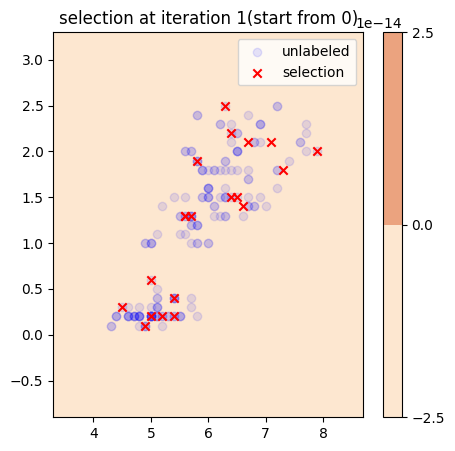

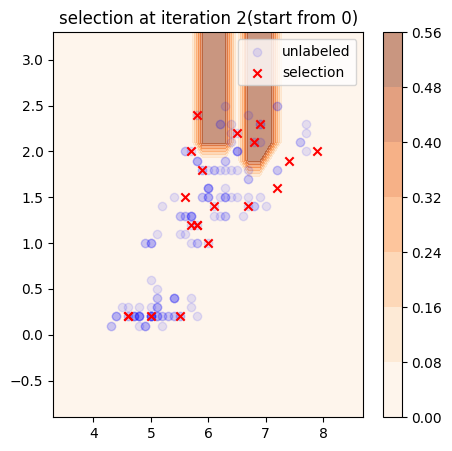

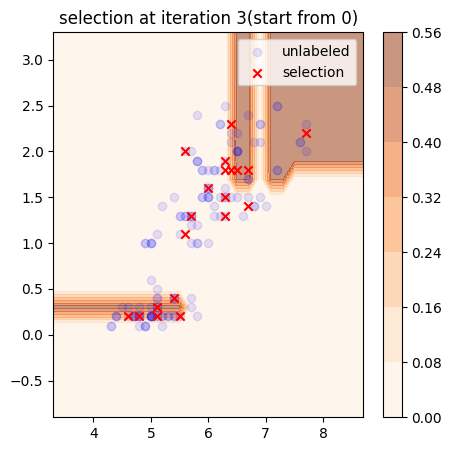

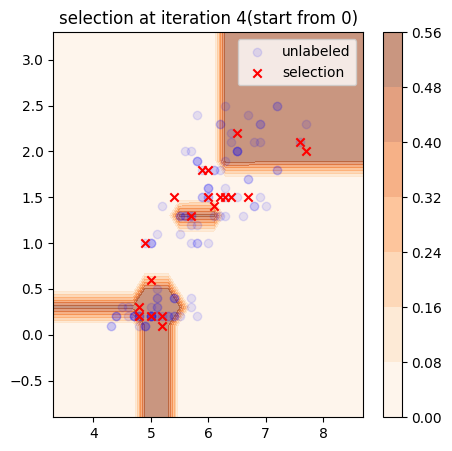

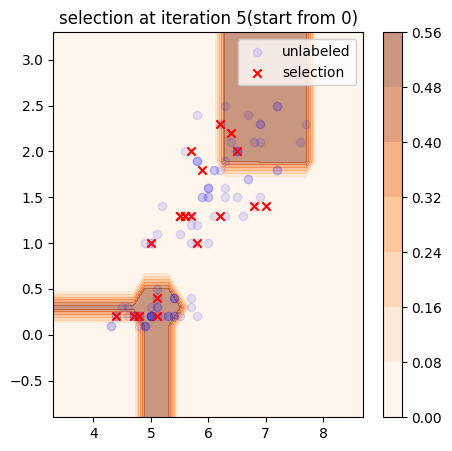

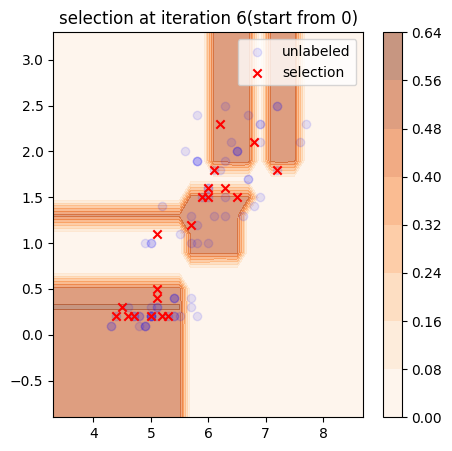

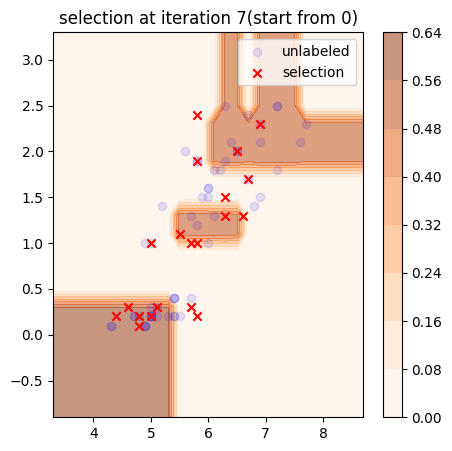

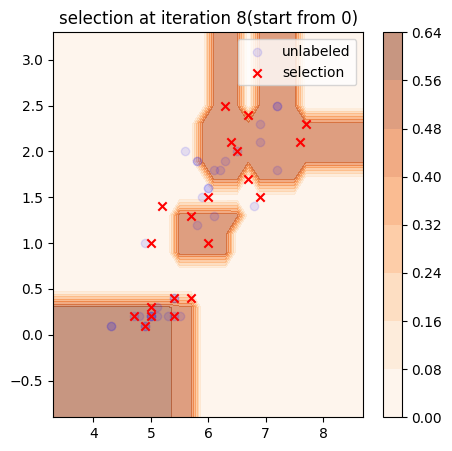

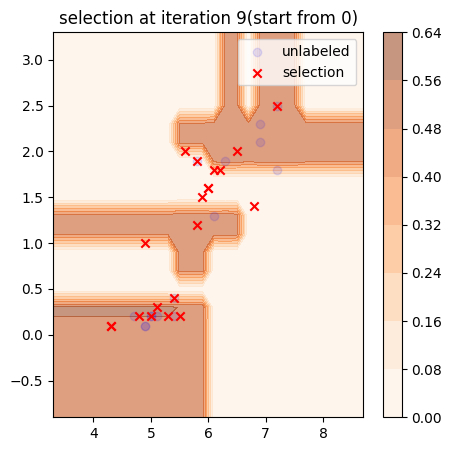

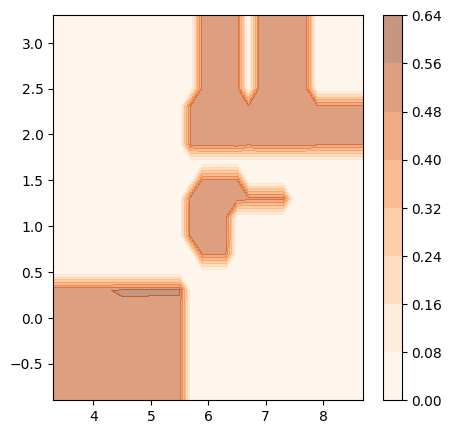

In [8]:
plot_selection(rand_iris, c_md_rand.stats[0], "img/iris_cat_rand")

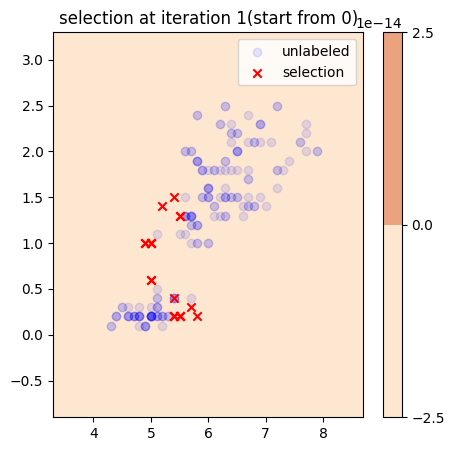

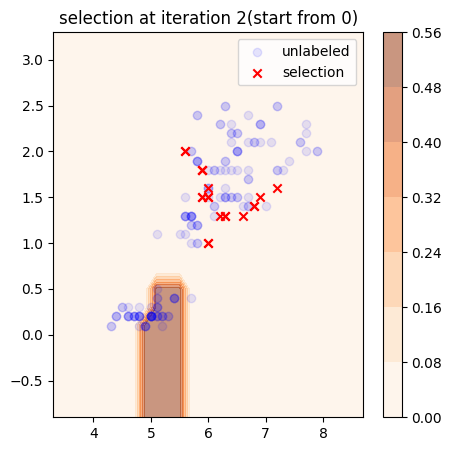

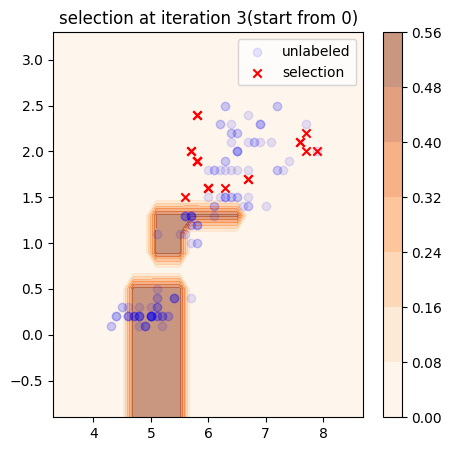

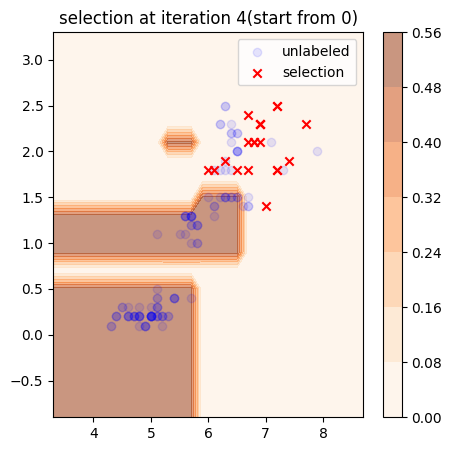

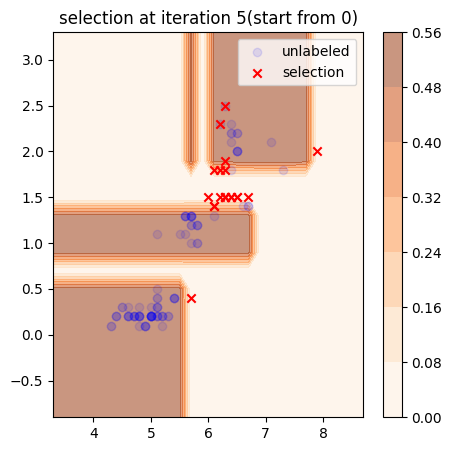

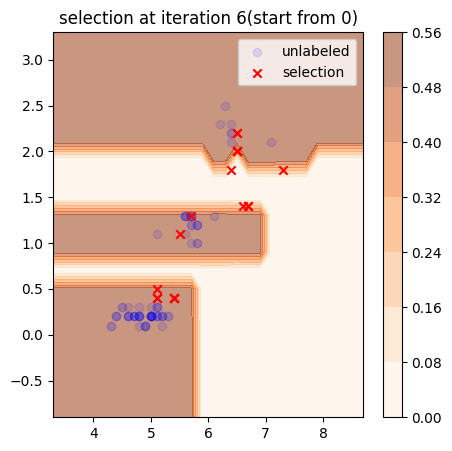

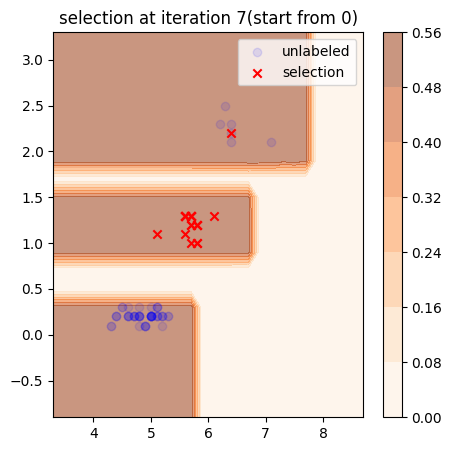

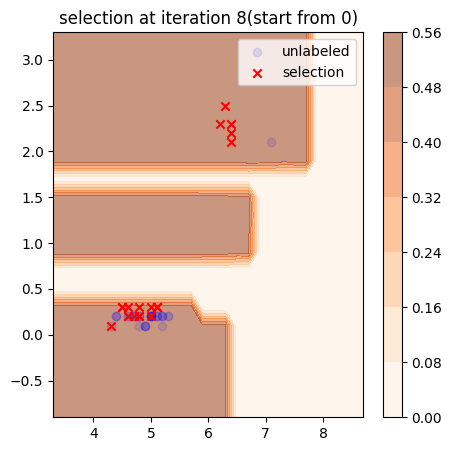

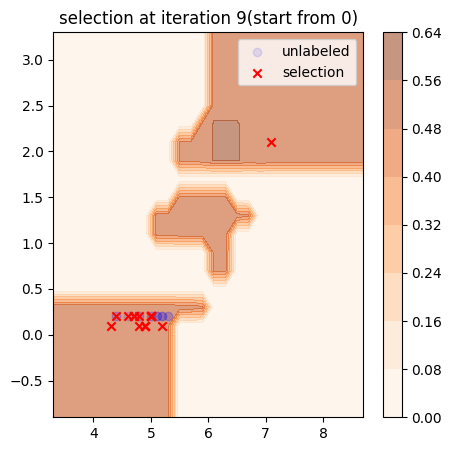

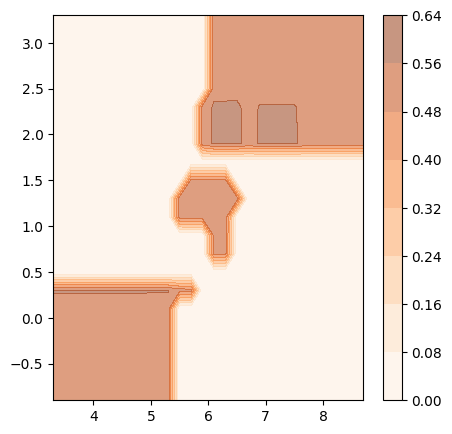

In [10]:
plot_selection(unc_etp_iris, c_md_etp.stats[0], "img/iris_cat_etp")

D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\COMP8800\lib\site-packages\sklearn\base.py:464: User

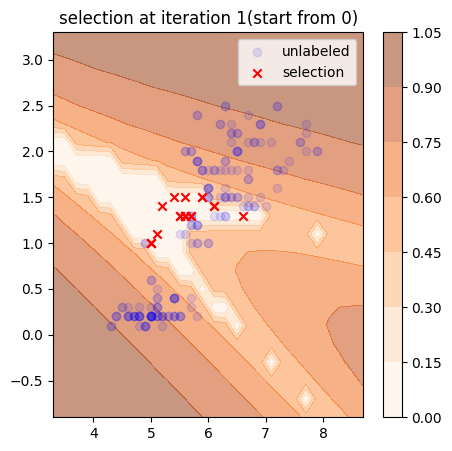

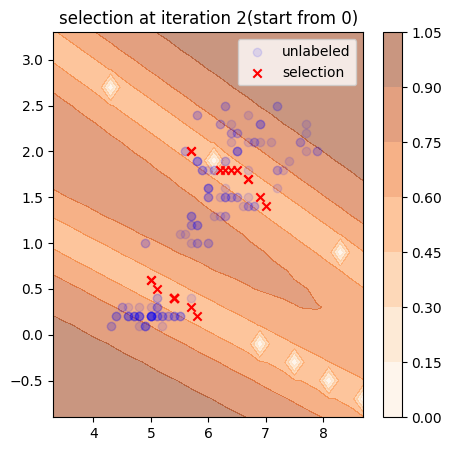

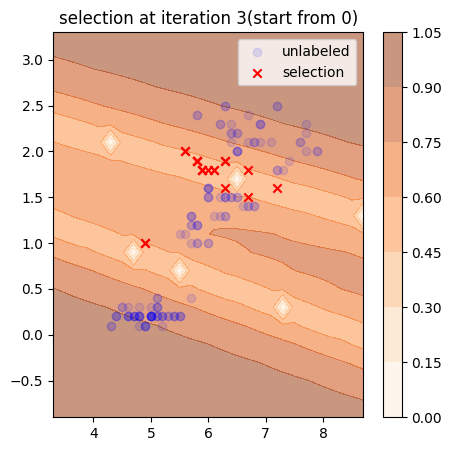

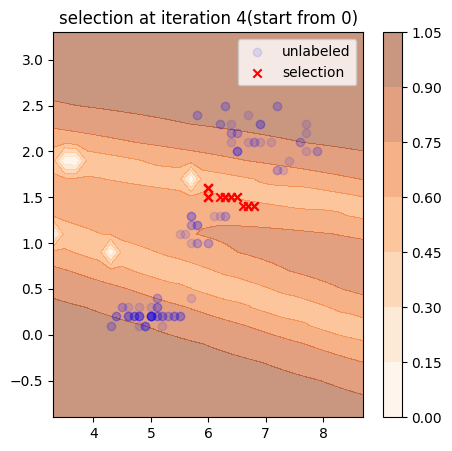

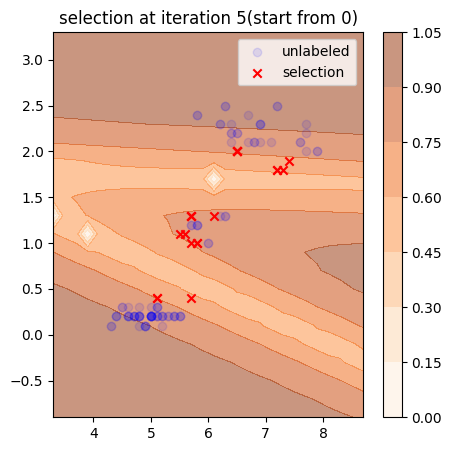

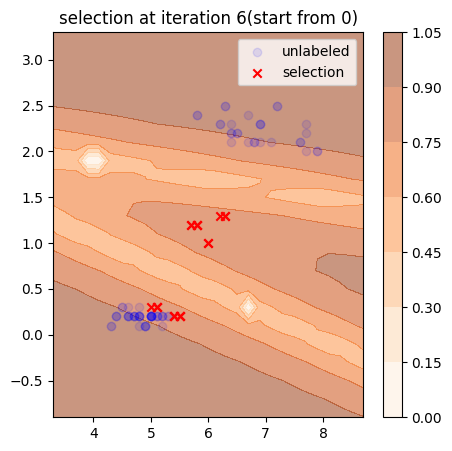

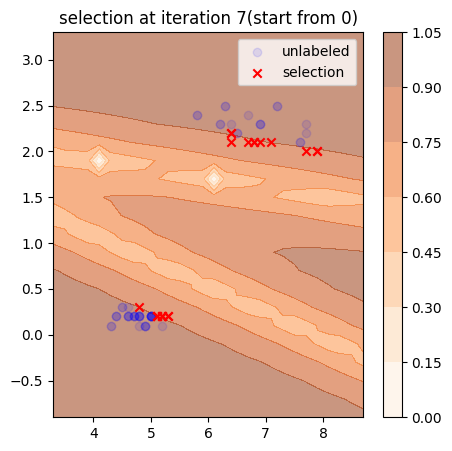

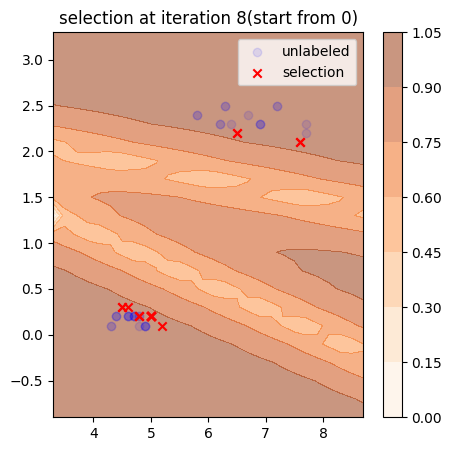

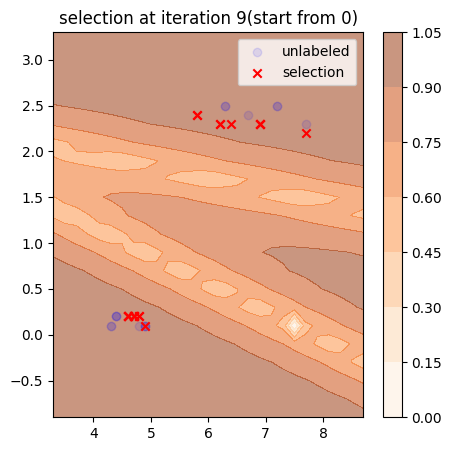

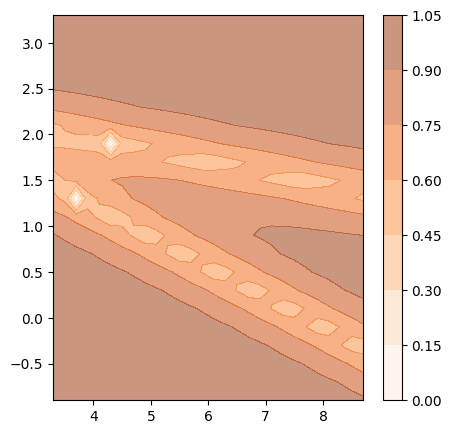

In [9]:
plot_selection(unc_iris, lr_md.stats[0], "img/iris_lr_unc")
# lr_md.stats[0]["model_snapshots"][1].coef_

In [ ]:

iris_dataset.reset()
x1, x2 = iris_dataset.u_x["sepal_length"], iris_dataset.u_x["petal_width"]
min1, max1 = data.iloc[:, 0].min()-1, data.iloc[:, 0].max()+1
min2, max2 = data.iloc[:, 1].min()-1, data.iloc[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.2)
x2grid = np.arange(min2, max2, 0.2)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))

# 
# c = ax.contourf(xx, yy, zz2, cmap='Purples', alpha=1)
# 
# plt.colorbar(c)
# c = ax.contourf(xx, yy, zz3, cmap='Greens', alpha=1)
# plt.colorbar(c)
snapshots = c_md.stats[0]["snapshot"]
l = snapshots[0]
for idx, snapshot in enumerate(snapshots):
    if idx == 0:
        continue
    fig, ax = plt.subplots(figsize=(5, 5))
    model = c_md.stats[0]["model_snapshots"][idx-1]
    yhat = model.predict_proba(grid)
    zz1 = yhat[:,0].reshape(xx.shape)
    zz2 = yhat[:,1].reshape(xx.shape)
    zz3 = yhat[:,2].reshape(xx.shape)
    # zma = zz.max(axis=1)
    zz1[zz1 < 0.5] = 0
    zz2[zz2 < 0.5] = 0 
    zz3[zz3 < 0.5] = 0 
    zz = zz1 + zz2 + zz3
    c = ax.contourf(xx, yy, zz, cmap='Oranges', alpha=0.5)
    plt.colorbar(c)
    if idx == 10:
        break
    l = l.union(snapshot)
    # cmap=plt.get_cmap("Oranges", 10)
    ax.scatter(x1.drop(l), x2.drop(l), c='b', alpha=0.1, label="unlabeled")
    ax.scatter(x1[snapshot], x2[snapshot], c='r', marker="x", label="selection")
    ax.set_title(f"selection at iteration {idx}(start from 0)")
    ax.legend()
    fig.savefig(f"img/iris_cat/{idx}.png")

(1000, 2)


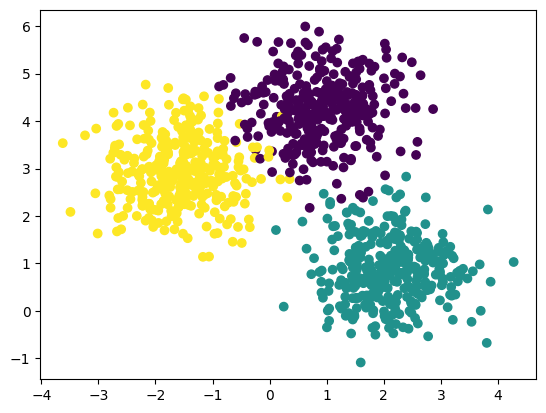

In [11]:
from sklearn.datasets import make_blobs
data, label = make_blobs(n_features=2, n_samples=1000, centers=3, random_state=0, cluster_std=0.7)
print(data.shape)
sct = plt.scatter(data[:,0], data[:,1], c=label)


In [15]:
SEEDS = [0]
params = {
    "init_size": 30,
    "batch_size": 20,
    "random_state": 0
}
blob_dataset = Dataset(data=data, label=label, al_metric=UncertainMetric(**params), shuffle=False, **params)
c_md = _c_md(model=None, eval_metrics=get_metrics(["accuracy"]), seeds=[0], dataset=blob_dataset, **params)

In [16]:
c_md.start()

  0%|          | 0/1 [00:00<?, ?it/s]

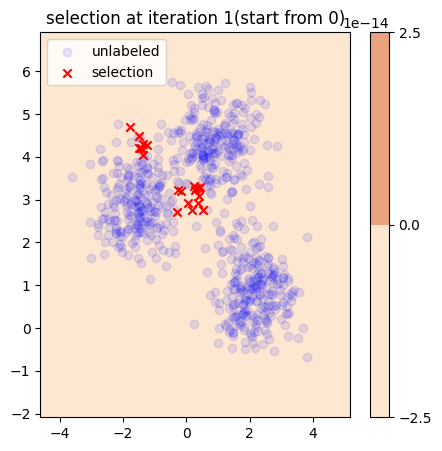

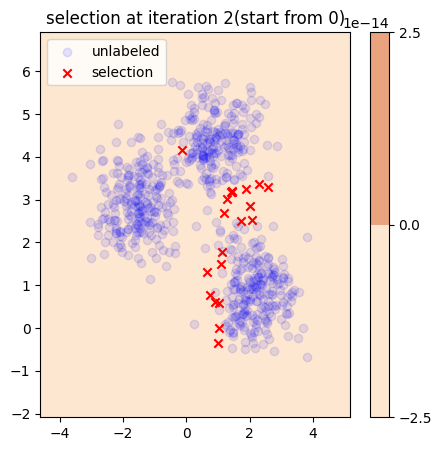

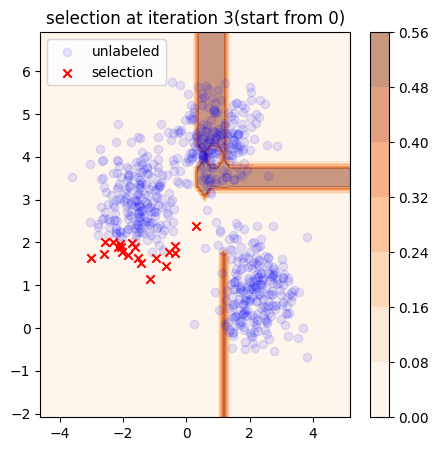

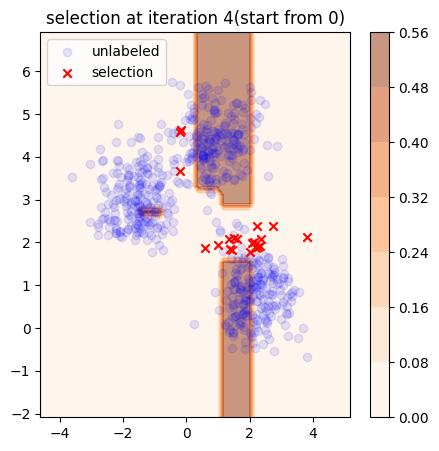

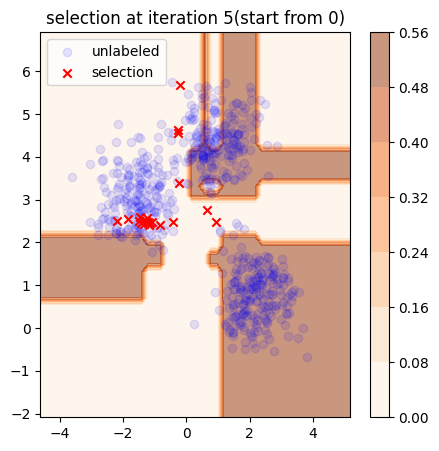

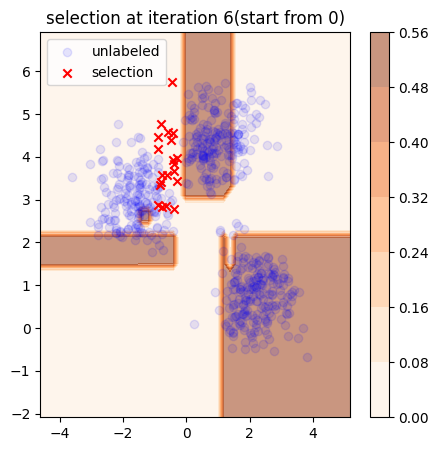

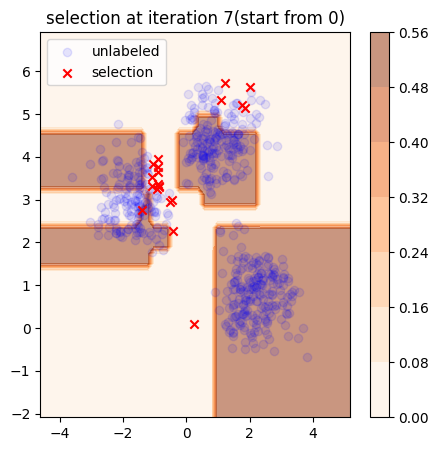

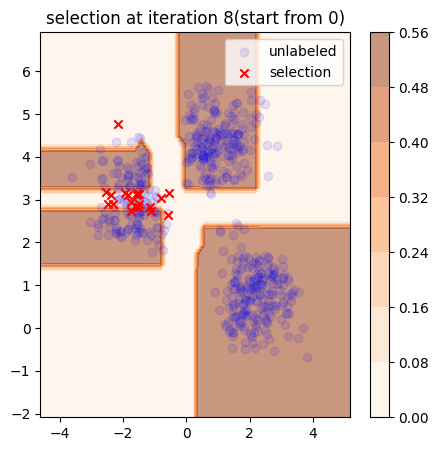

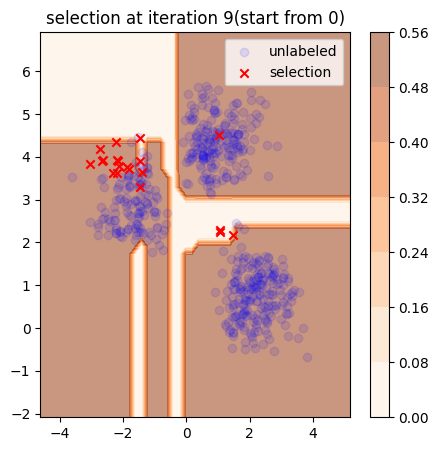

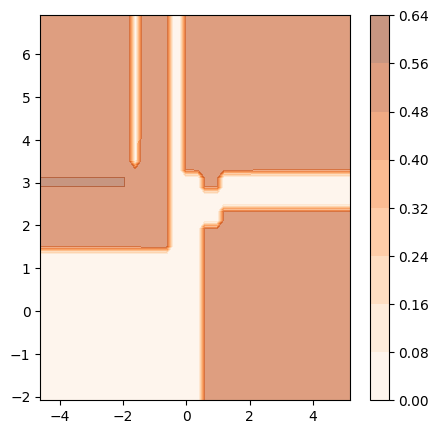

In [20]:
plot_selection(blob_dataset, c_md.stats[0], "img/blob_cat_unc")